#### date: 08/02/2022
#### goal: code for plotting time series of variables displayed in the file and a table displaying data availability
#### Author: Claudia Acquistapace

In [6]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import watermark.watermark as watermark


watermark(iversions=True, globals_=globals())

# data path and file name for tsg
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'
radar_path = '/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/'
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

# variable list
var_list = ['LHF', 'SHF', 'MR', 'theta', 'hspd', 'hdir', 'Ze', 'Vd', 'LWP', 'cloud_fraction']

# reading ARthus and Doppler lidar daily files together
LHF_file_list = np.sort(glob.glob(data_path+'LHF*.nc'))
lhf_dataset = xr.open_mfdataset(LHF_file_list)
SHF_file_list = np.sort(glob.glob(data_path+'SHF*.nc'))
shf_dataset = xr.open_mfdataset(SHF_file_list)
MR_file_list = np.sort(glob.glob(data_path+'MR*.nc'))
mr_dataset = xr.open_mfdataset(MR_file_list)
theta_file_list = np.sort(glob.glob(data_path+'theta*.nc'))
theta_dataset = xr.open_mfdataset(theta_file_list)
hspd_file_list = np.sort(glob.glob(data_path+'*H_wind_speed_dir_no_dc.nc'))
hspd_dataset = xr.open_mfdataset(hspd_file_list)
w_file_list = np.sort(glob.glob(data_path+'VW*.nc'))
w_dataset = xr.open_mfdataset(w_file_list)

# reading radar files together
radar_file_list = np.sort(glob.glob(radar_path+"*.nc"))[14:16]
radar_dataset = xr.open_mfdataset(radar_file_list)

# reading and selecting SSTs from the 2nd and 3rd February
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
sst_dataset      = xr.Dataset(data_vars = variables,
                       coords = coords)

ModuleNotFoundError: No module named 'watermark'

In [2]:
w_dataset.product_no_noise.values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.16574174, 0.34467649, 0.35476953, ...,        nan,        nan,
               nan],
       [0.15708493, 0.26971362,        nan, ...,        nan,        nan,
               nan],
       [0.33113825,        nan,        nan, ...,        nan,        nan,
               nan]])

In [3]:
hspd_dataset

<xarray.Dataset>
Dimensions:                   (height: 400, time: 1782)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:01:02.28283...
  * height                    (height) float64 0.0 21.21 ... 8.442e+03 8.463e+03
Data variables:
    H_speed_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(864, 400), meta=np.ndarray>
    H_dir_no_diurnal_cycle    (time, height) float64 dask.array<chunksize=(864, 400), meta=np.ndarray>
    H_speed_no_noise          (time, height) float64 dask.array<chunksize=(864, 400), meta=np.ndarray>
    H_dir_no_noise            (time, height) float64 dask.array<chunksize=(864, 400), meta=np.ndarray>
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2022-03-04 11:14:10.816733
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  Doppler lidar variables with the diurnal cycle removed...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       Doppler lidar data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  Doppler lidar system
    COMMENT:           data only for the 20200202 because no data is availabl...

In [4]:
lhf_availability = ~lhf_dataset.product_no_noise.isnull().values.all(axis=1)
mr_availability = ~mr_dataset.product_no_noise.isnull().values.all(axis=1)
hwsp_availability = ~hspd_dataset.H_speed_no_noise.isnull().values.all(axis=1)
radar_availability = radar_dataset.time.isnull().values.all(axis=0)
Doppler_zenith_availability = ~w_dataset.product_no_noise.isnull().values.all(axis=1)

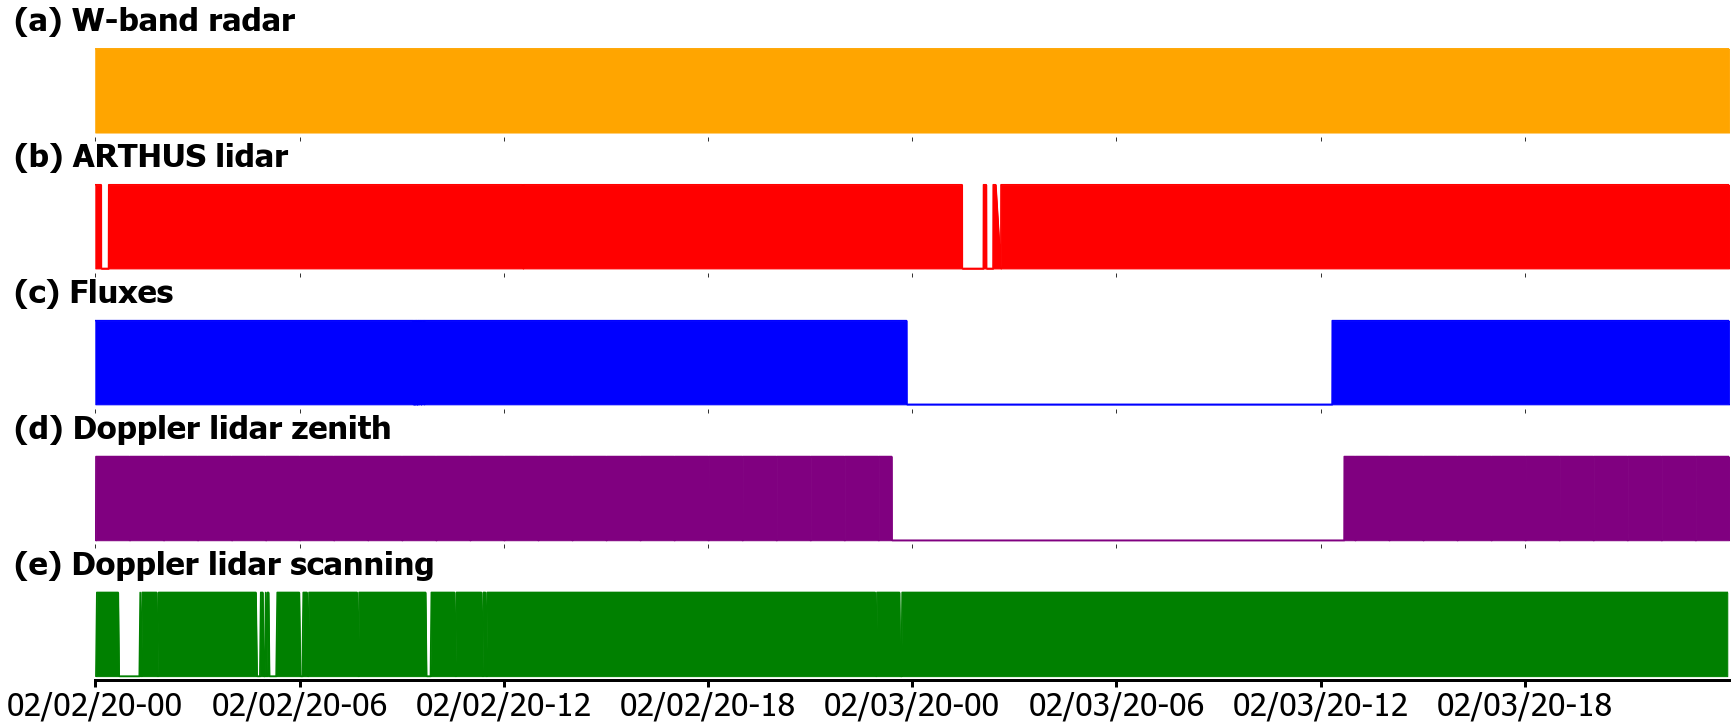

In [5]:
# plot of the time series for all variables 
dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :10,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}



# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(5,1, figsize=(24,10), sharex=True, sharey=True, constrained_layout=True)

axs[0].plot(radar_dataset.time.values, np.ones(len(radar_dataset.time.values))*10, color='orange')
axs[0].fill_between(radar_dataset.time.values, 0., np.ones(len(radar_dataset.time.values))*10, color='orange')
axs[0].spines["bottom"].set_visible(False)

axs[1].plot(mr_dataset.time.values, mr_availability*10, color='red')
axs[1].fill_between(mr_dataset.time.values, 0., mr_availability*10, color='red')
axs[1].spines["bottom"].set_visible(False)

axs[2].plot(lhf_dataset.time.values, lhf_availability*10, color='blue')
axs[2].fill_between(lhf_dataset.time.values, 0., lhf_availability*10, color='blue')
axs[2].spines["bottom"].set_visible(False)

axs[3].plot(w_dataset.time.values, Doppler_zenith_availability*10, color='purple')
axs[3].fill_between(w_dataset.time.values, 0., Doppler_zenith_availability*10, color='purple')
axs[3].spines["bottom"].set_visible(False)

axs[4].plot(hspd_dataset.time.values, hwsp_availability*10, color='green')
axs[4].fill_between(hspd_dataset.time.values, 0., hwsp_availability*10, color='green')
axs[4].spines["bottom"].set_linewidth(3)
axs[4].xaxis.set_major_formatter(mdates.DateFormatter("%D-%H"))
axs[4].tick_params(which='minor', length=5, width=2)
axs[4].tick_params(which='major', length=7, width=3)

for ax, l in zip(axs[:].flatten(), ['(a) W-band radar', \
                                    '(b) ARTHUS lidar',
                                    '(c) Fluxes ', 
                                    '(d) Doppler lidar zenith',
                                    '(e) Doppler lidar scanning']):
    ax.text(-0.05, 1.15, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    ax.axes.yaxis.set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    #ax.tick_params(which='minor', length=5, width=2)
    #ax.tick_params(which='major', length=7, width=3)
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    #ax.tick_params(axis='both', labelsize=32)
    ax.set_xlim(t_start,t_end)
fig.savefig(path_out_plots+'data_availability.png', format='png')

In [6]:
# read SST temperature
# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# opening noise mask file to read cloud base
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)
noise_mask = noise_mask.sel(Time=slice(datetime(2020,2,2,0,0,0), datetime(2020,2,3,23,59,59)))
cloud_base = noise_mask.cloud_base_height.values


# opening data and thermodynamic properties derived from radiosondes
rs_vars_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/thermodyn_properties_RS.nc'
rs_dataset = xr.open_dataset(rs_vars_file)


# atl: R/V Atalante, mer: R/V Maria S. Merian, met: R/V Meteor, rhb: Ron H. Brown, bco: Barbados Cloud Observatory.
rootdir = '/Volumes/Extreme SSD/Downloads/'
# Paths to QC TSG: Quality Check ThermoSalinoGraph.
path2atlQCTSG = '/Users/claudia/Downloads/'


# Read the Atalante QC TSG data.
filename_dat = path2atlQCTSG + 'Atalante_traj_gosud3_2001-18022020-cor'

# Read the dat file.
ndf = pd.read_csv(filename_dat, delimiter='\s+', header=None, engine='python',
                  names=['year','month','day','hour','minute','second', 'lon', 'lat', 'salt', 'temp', 'bho'])

df = pd.DataFrame({'year': ndf.year,
                   'month': ndf.month,
                   'day': ndf.day,
                   'hour': ndf.hour,
                   'minute': ndf.minute,
                   'second': ndf.second})


time_atlqctsg = pd.to_datetime(df)
lon_atlqctsg = ndf.lon
lat_atlqctsg = ndf.lat

# Remove the outliers.
temp_atlqctsg = ndf.temp
temp_atlqctsg[ndf.temp>28] = np.NaN

# Define the time window of interest YYYY-MM-DD
datestr_start = '2020-02-02'
datestr_end = '2020-02-04'
date_start = np.datetime64(datestr_start)
date_end = np.datetime64(datestr_end)
idtime_atlqctsg = (time_atlqctsg>date_start) & (time_atlqctsg<date_end)

/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7516/1879998706.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_atlqctsg[ndf.temp>28] = np.NaN


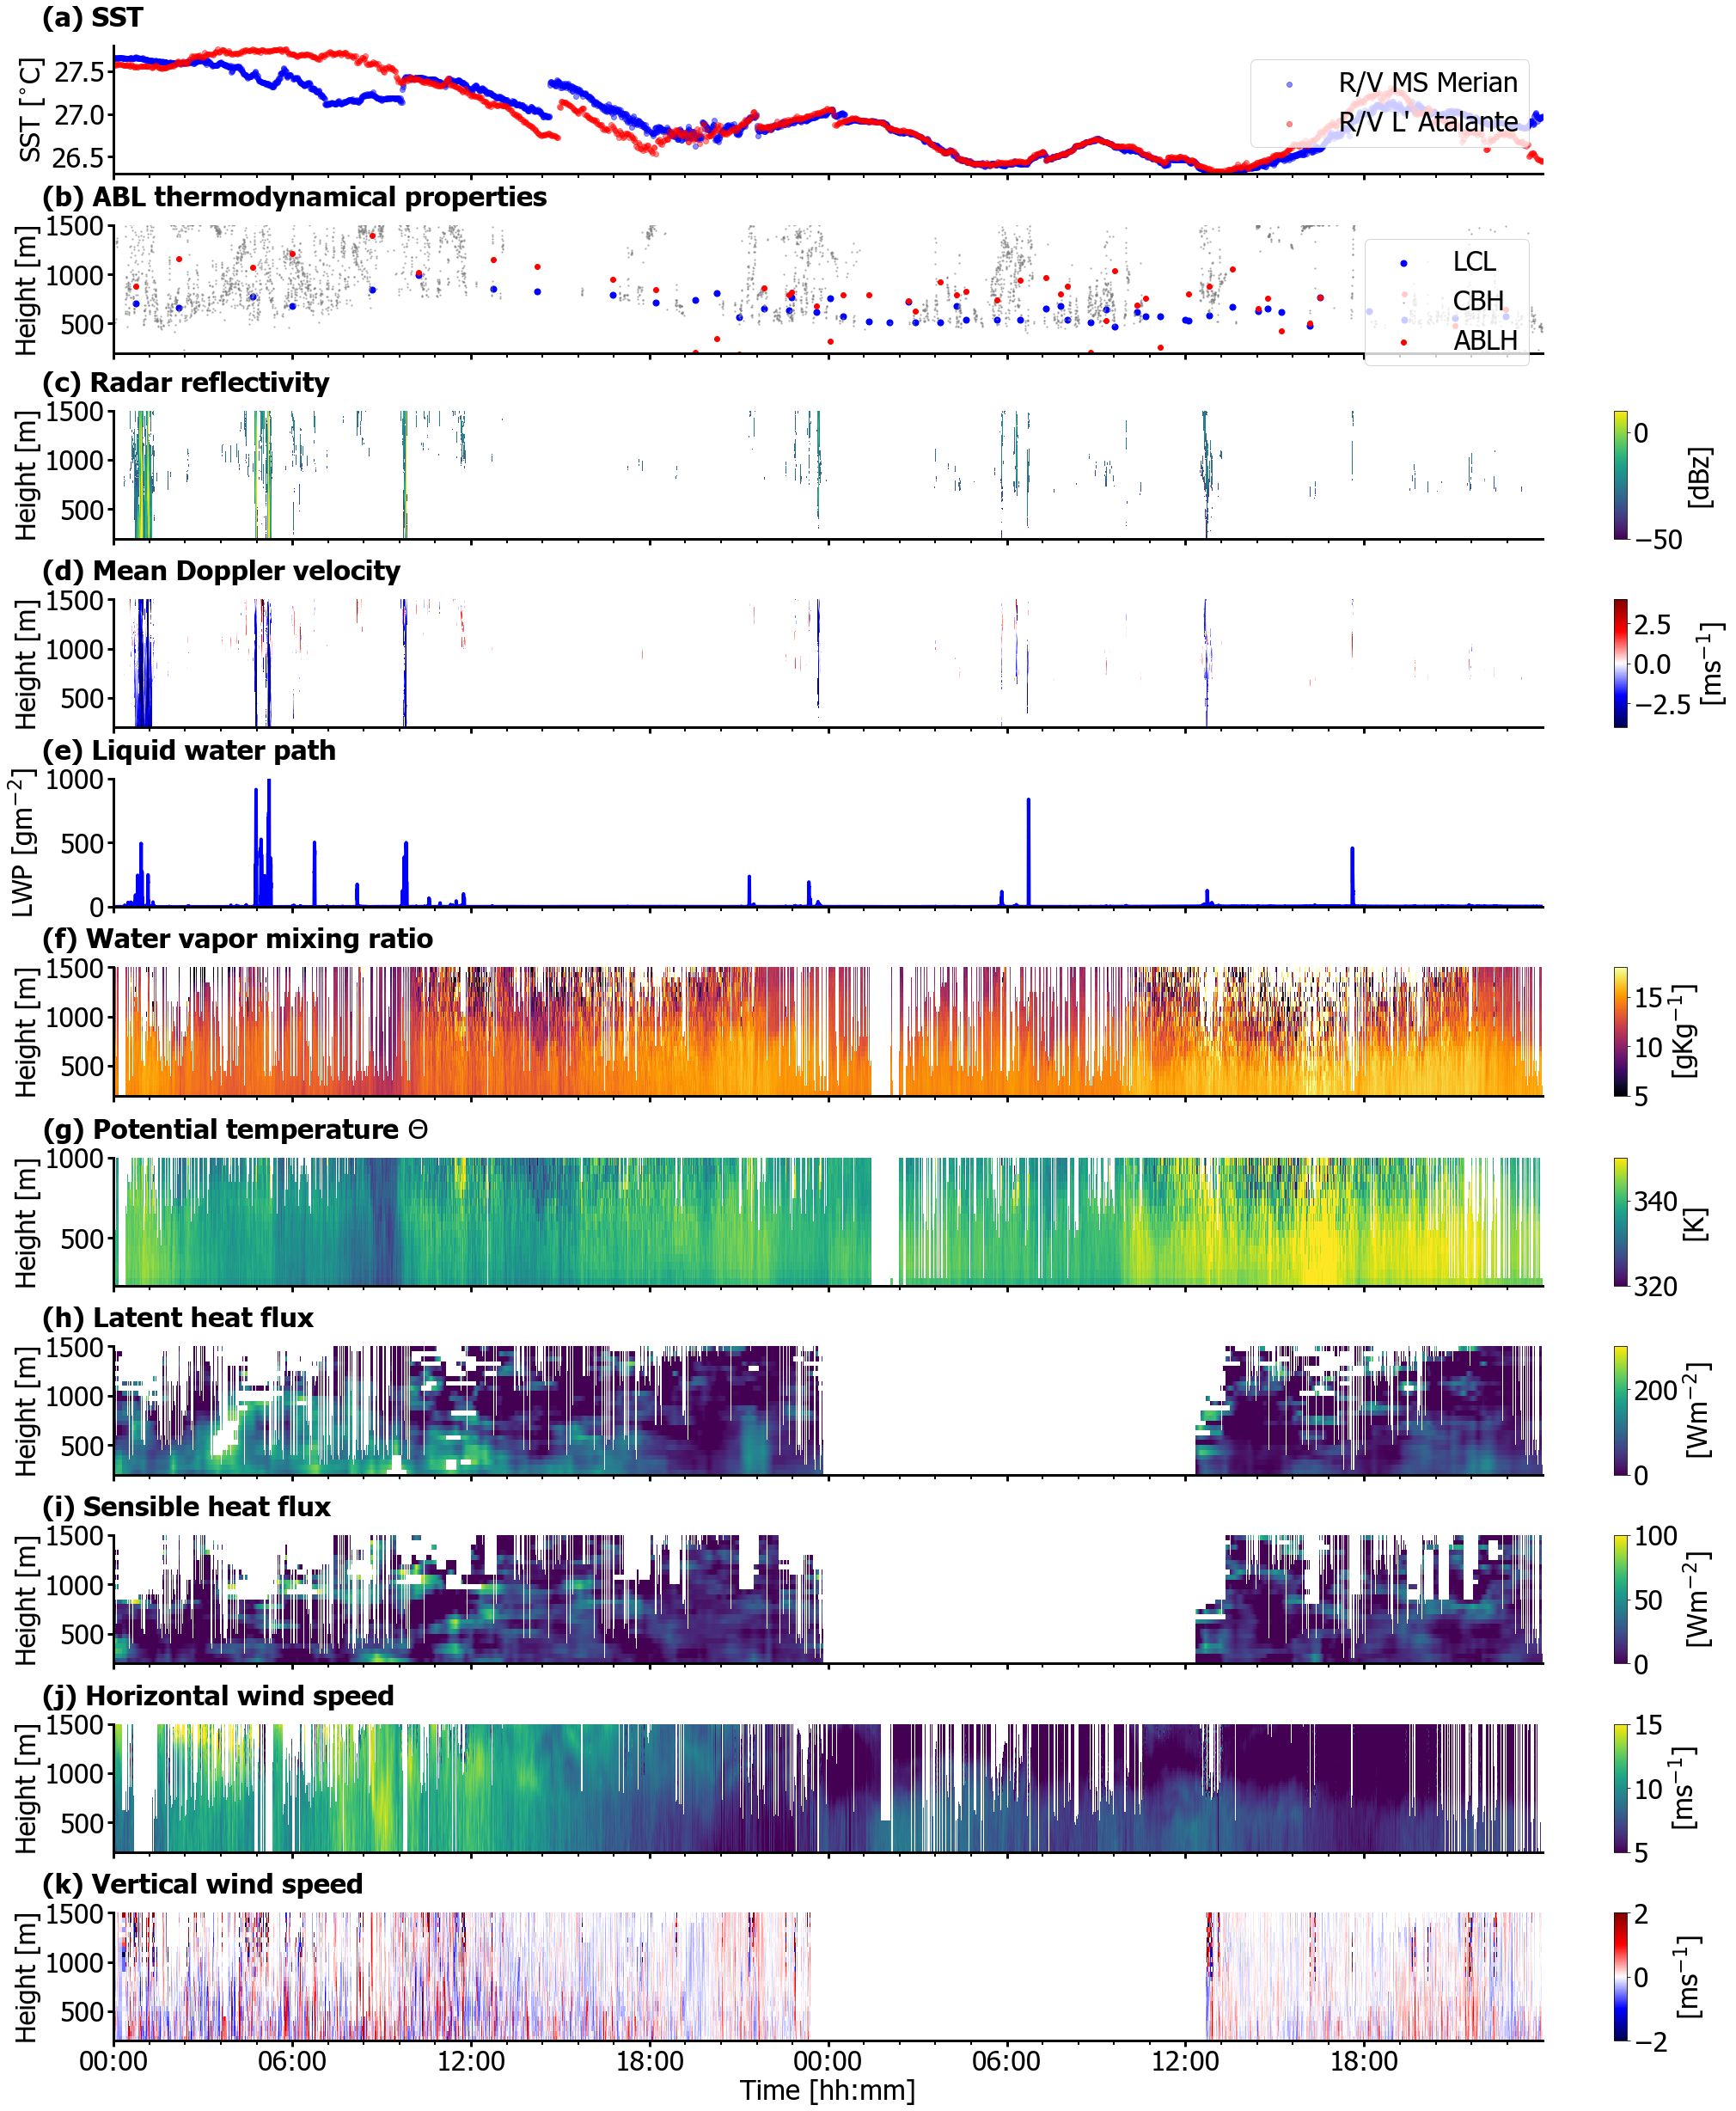

In [10]:


fig, axs = plt.subplots(11,1,figsize=(28,34), sharex=True, constrained_layout=True)
ymin = 200.
ymax = 1500.

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

# plot of sst
axs[0].scatter(SST_DS.time.values, SST_DS.SST.values, color='blue', alpha=0.45, label='R/V MS Merian')
#axs[0].set_xlabel('Time [mm-dd hh]', fontsize=fontSizeX)
axs[0].scatter(time_atlqctsg[idtime_atlqctsg],temp_atlqctsg[idtime_atlqctsg],color='red', alpha=0.45, label='R/V L\' Atalante')
axs[0].legend(frameon=True, loc='upper right')
axs[0].set_ylim(26.3,27.8)
axs[0].set_ylabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

# plot of thermodynamical properties from RS
axs[1].scatter(rs_dataset.time.values, rs_dataset.lcl.values, label='LCL', s=50., color='blue')
axs[1].scatter(noise_mask.Time.values, cloud_base, color='grey', label='CBH', s=2., alpha=0.45)
axs[1].scatter(rs_dataset.time.values, rs_dataset.pblh.values, label='ABLH', color='red')
axs[1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1].set_ylim(ymin,ymax)
axs[1].legend(frameon=True, loc='upper right')



# plot of radar reflectivity
time_r = radar_dataset.time.values
height_r = radar_dataset.height.values
Ze = radar_dataset.radar_reflectivity.values
mesh = axs[2].pcolormesh(time_r, height_r, Ze.T, cmap='viridis', vmin=-50., vmax=10.)
cbar = fig.colorbar(mesh, ax=axs[2], aspect=cbarAspect)
cbar.set_label(label='[dBz]',  size=fontSizeX)
axs[2].set_ylim(ymin,ymax)
axs[2].set_ylabel('Height [m]', fontsize=fontSizeX)


# plot of mean Doppler velocity
Vd = radar_dataset.mean_doppler_velocity.values
mesh2 = axs[3].pcolormesh(time_r, height_r, Vd.T, cmap='seismic', vmin=-4., vmax=4.)
cbar = fig.colorbar(mesh2, ax=axs[3], aspect=cbarAspect)
cbar.set_label(label='[ms$^{-1}$]',  size=fontSizeX)
axs[3].set_ylim(ymin,ymax)
axs[3].set_ylabel('Height [m]', fontsize=fontSizeX)

# plot of LWP 
mesh = axs[4].plot(time_r,radar_dataset.liquid_water_path.values, color='b', linewidth=4)
axs[4].set_ylim(0.,1000.)
axs[4].set_ylabel('LWP [gm$^{-2}$]', fontsize=fontSizeX)
# axs[3].set_yscale('log')


# plot of wvmr
time_l = mr_dataset.time.values
height_l = mr_dataset.height.values
mr = mr_dataset.product_no_noise.values
mesh3 = axs[5].pcolormesh(time_l, height_l, mr.T, cmap='inferno', vmin=5., vmax=18.)
cbar = fig.colorbar(mesh3, ax=axs[5], aspect=cbarAspect)
cbar.set_label(label='[gKg$^{-1}$]',  size=fontSizeX)
axs[5].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[5].set_ylim(ymin,ymax)



#plot of theta
time_l = theta_dataset.time.values
height_l = theta_dataset.height.values
theta = theta_dataset.product_no_noise.values
mesh4 = axs[6].pcolormesh(time_l, height_l, theta.T, cmap='viridis', vmin=320., vmax=350.)
cbar = fig.colorbar(mesh4, ax=axs[6], aspect=cbarAspect)
cbar.set_label(label='[K]',  size=fontSizeX)
axs[6].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[6].set_ylim(200.,1000.)



# plot of LHF
time_f = lhf_dataset.time.values
height_f = lhf_dataset.height.values
lhf = lhf_dataset.product_no_noise.values
mesh5 = axs[7].pcolormesh(time_f, height_f, lhf.T, cmap='viridis', vmin=0., vmax=300.)
cbar = fig.colorbar(mesh5, ax=axs[7], aspect=cbarAspect)
cbar.set_label(label='[Wm$^{-2}$]',  size=fontSizeX)
axs[7].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[7].set_ylim(ymin,ymax)


# plot of SHF
time_f2 = shf_dataset.time.values
height_f2 = shf_dataset.height.values
shf = shf_dataset.product_no_noise.values
mesh6 = axs[8].pcolormesh(time_f2, height_f2, shf.T, cmap='viridis', vmin=0., vmax=100.)
cbar = fig.colorbar(mesh6, ax=axs[8], aspect=cbarAspect)
cbar.set_label(label='[Wm$^{-2}$]',  size=fontSizeX)
axs[8].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[8].set_ylim(ymin,ymax)


# plot of H speed
time_d = hspd_dataset.time.values
height_d = hspd_dataset.height.values
hspd = hspd_dataset.H_speed_no_noise.values
mesh7 = axs[9].pcolormesh(time_d, height_d, hspd.T, cmap='viridis', vmin=5., vmax=15.)
cbar = fig.colorbar(mesh7, ax=axs[9], aspect=cbarAspect)
cbar.set_label(label='[ms$^{-1}$]',  size=fontSizeX)
axs[9].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[9].set_ylim(ymin,ymax)


# plot of vertical velocity
w_wind = w_dataset.product_no_noise.values
w_time = w_dataset.time.values
w_height = w_dataset.height.values
mesh8 = axs[10].pcolormesh(w_time, w_height, w_wind.T, cmap='seismic', vmin=-2., vmax=2.)
cbar = fig.colorbar(mesh8, ax=axs[10], aspect=cbarAspect)
cbar.set_label(label='[ms$^{-1}$]',  size=fontSizeX)
axs[10].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[10].set_ylim(ymin,ymax)





#cbar = fig.colorbar(mesh, ax=axs[1])
#cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)
axs[10].set_xlabel('Time [hh:mm]', fontsize=fontSizeX)
axs[10].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))



for ax, l in zip(axs[:].flatten(), ['(a) SST ', \
                                    '(b) ABL thermodynamical properties', \
                                    '(c) Radar reflectivity ', \
                                    '(d) Mean Doppler velocity ',
                                    '(e) Liquid water path', 
                                    '(f) Water vapor mixing ratio', 
                                    '(g) Potential temperature $\\Theta$', 
                                    '(h) Latent heat flux', 
                                    '(i) Sensible heat flux', 
                                    '(j) Horizontal wind speed', 
                                    '(k) Vertical wind speed']):
    ax.text(-0.05, 1.15, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_xlim(t_start,t_end)
fig.savefig(path_out_plots+'figure_time_serie_all.png', format='png')

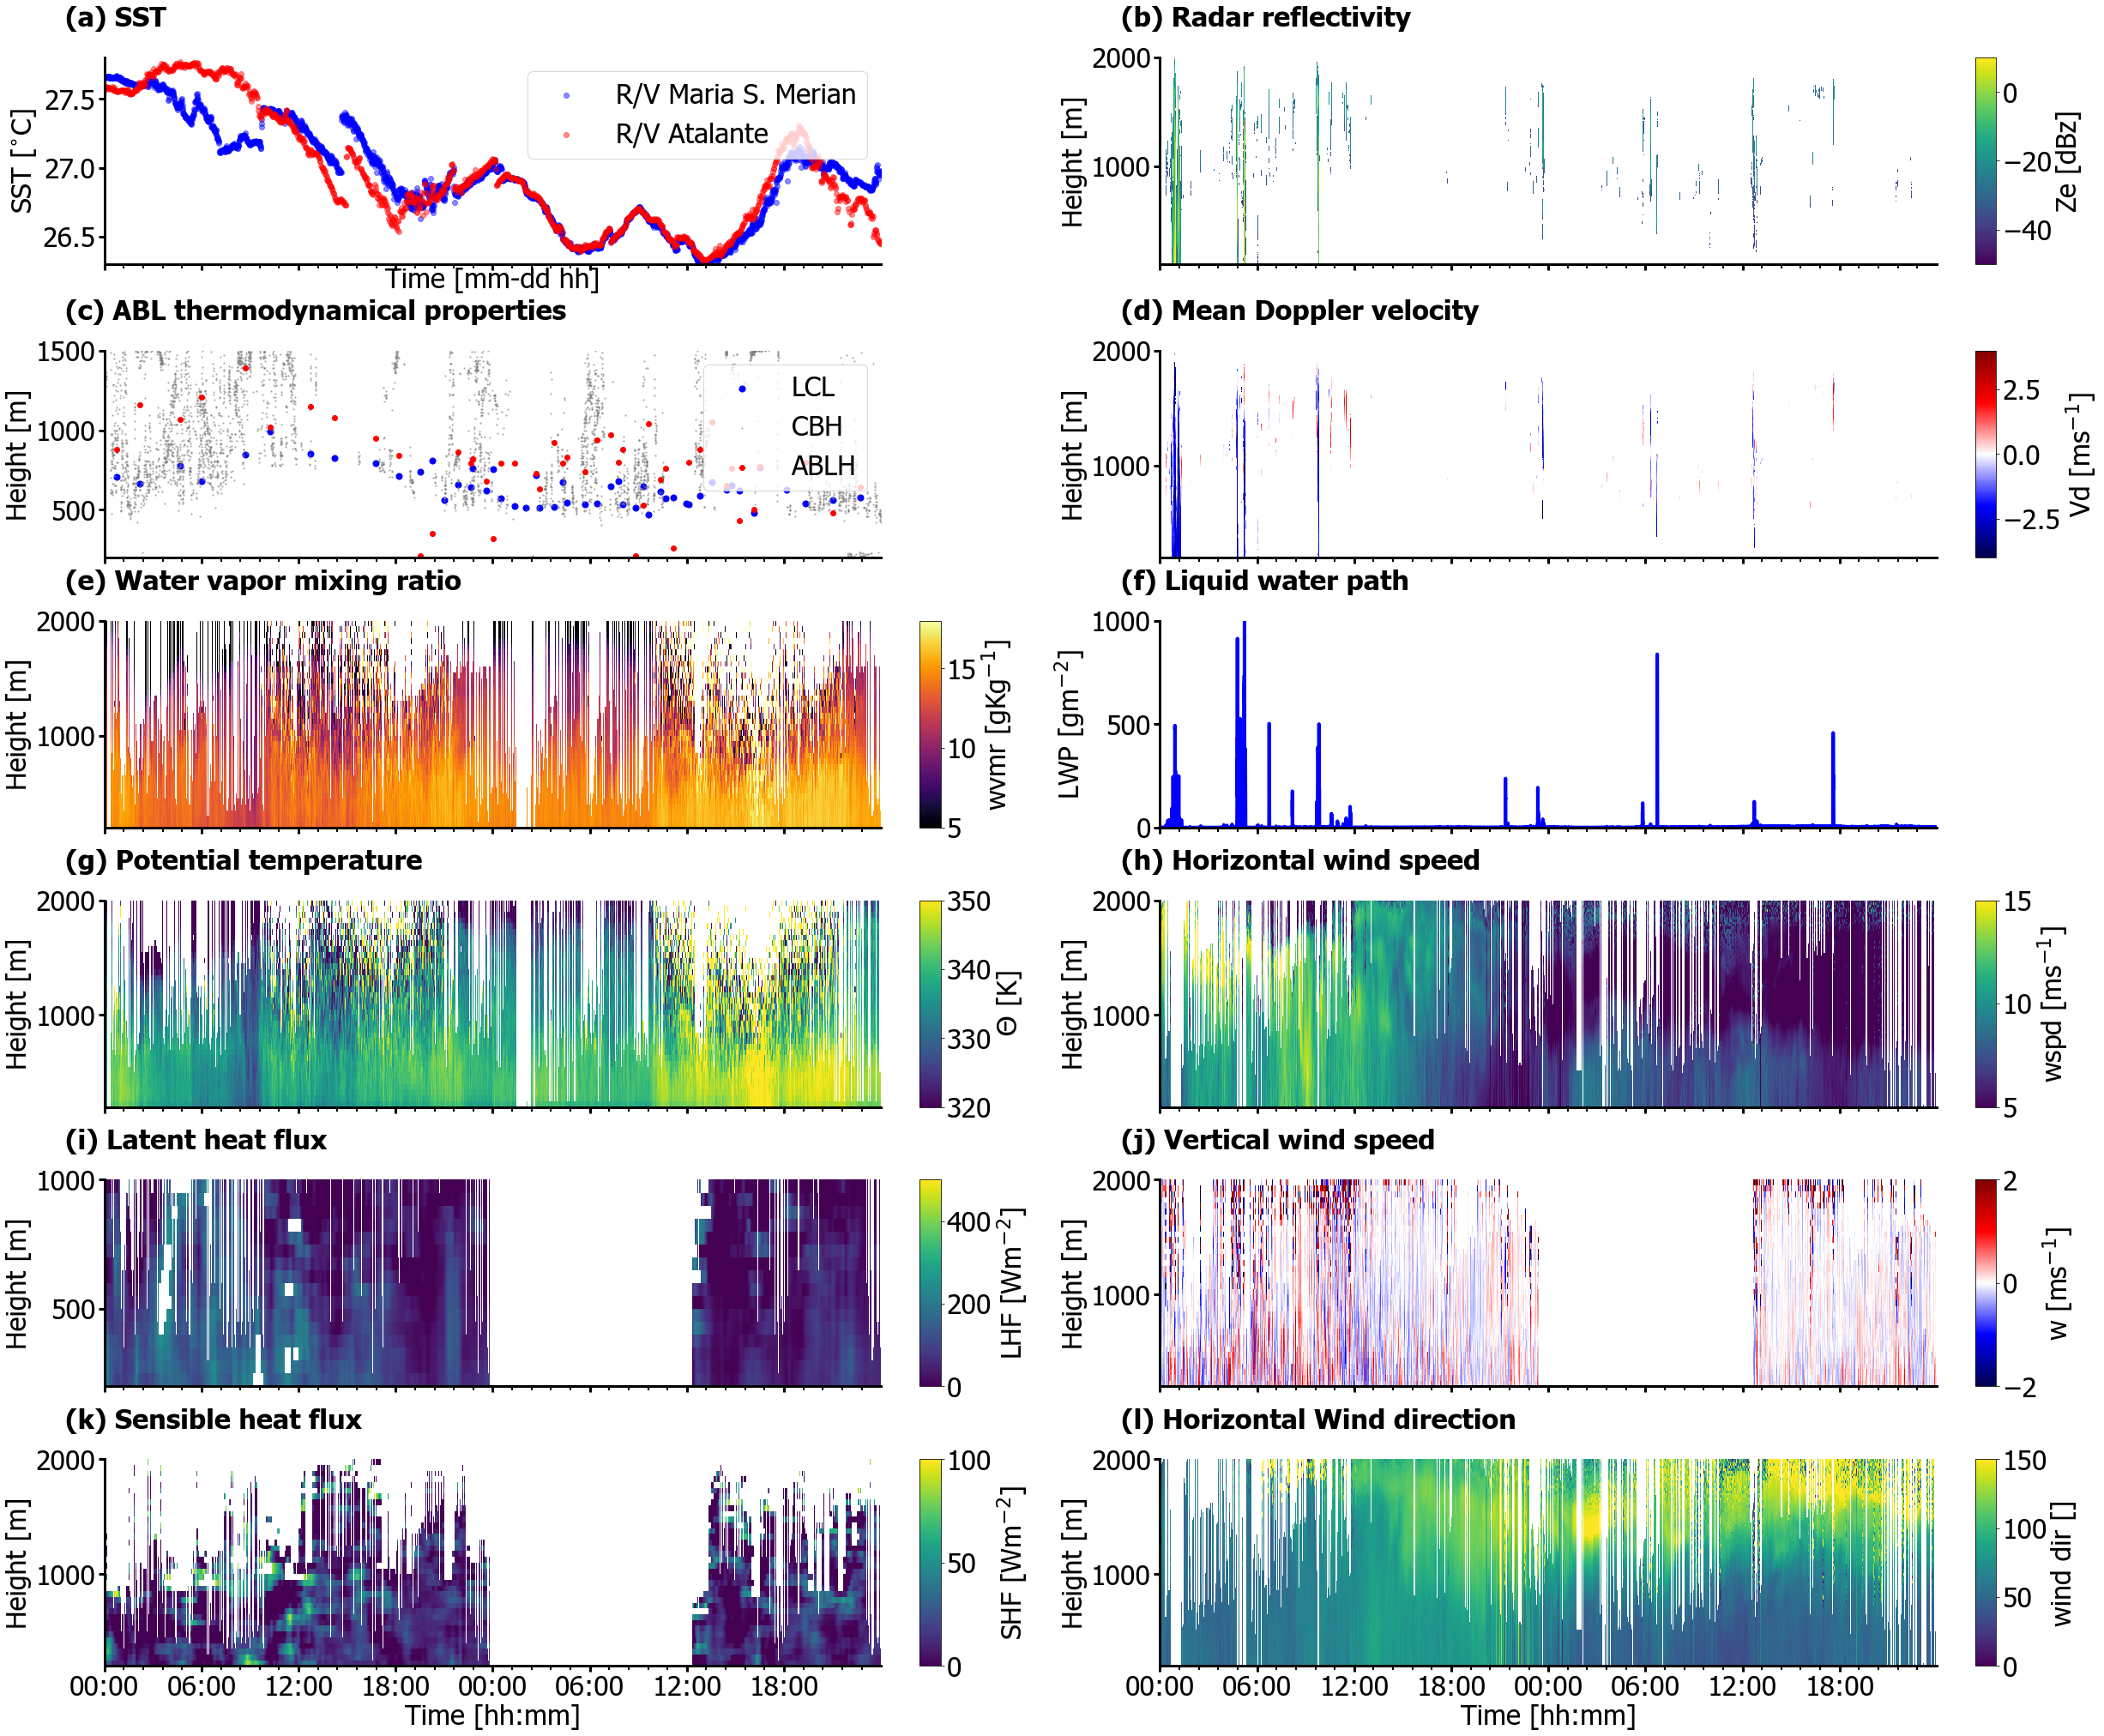

In [30]:


fig, axs = plt.subplots(6,2,figsize=(34,28), sharex=True, constrained_layout=True)
ymin = 200.
ymax = 2000.

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

# plot of sst
axs[0,0].scatter(SST_DS.time.values, SST_DS.SST.values, color='blue', alpha=0.45, label='R/V Maria S. Merian')
axs[0,0].set_xlabel('Time [mm-dd hh]', fontsize=fontSizeX)
axs[0,0].scatter(time_atlqctsg[idtime_atlqctsg],temp_atlqctsg[idtime_atlqctsg],color='red', alpha=0.45, label='R/V Atalante')
axs[0,0].legend(frameon=True, loc='')
axs[0,0].set_ylim(26.3,27.8)
axs[0,0].set_ylabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

# plot of thermodynamical properties from RS
axs[1,0].scatter(rs_dataset.time.values, rs_dataset.lcl.values, label='LCL', s=50., color='blue')
axs[1,0].scatter(noise_mask.Time.values, cloud_base, color='grey', label='CBH', s=2., alpha=0.45)
axs[1,0].scatter(rs_dataset.time.values, rs_dataset.pblh.values, label='ABLH', color='red')
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200., 1500.)
axs[1,0].legend(frameon=True)


# plot of wvmr
time_l = mr_dataset.time.values
height_l = mr_dataset.height.values
mr = mr_dataset.product_no_noise.values
mesh3 = axs[2,0].pcolormesh(time_l, height_l, mr.T, cmap='inferno', vmin=5., vmax=18.)
cbar = fig.colorbar(mesh3, ax=axs[2,0], aspect=cbarAspect)
cbar.set_label(label='wvmr [gKg$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[2,0].set_ylim(ymin,ymax)


#plot of theta
time_l = theta_dataset.time.values
height_l = theta_dataset.height.values
theta = theta_dataset.product_no_noise.values
mesh4 = axs[3,0].pcolormesh(time_l, height_l, theta.T, cmap='viridis', vmin=320., vmax=350.)
cbar = fig.colorbar(mesh4, ax=axs[3,0], aspect=cbarAspect)
cbar.set_label(label='$\Theta$ [K]',  size=fontSizeX)
axs[3,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,0].set_ylim(ymin,ymax)



# plot of LHF
time_f = lhf_dataset.time.values
height_f = lhf_dataset.height.values
lhf = lhf_dataset.product_no_noise.values
mesh5 = axs[4,0].pcolormesh(time_f, height_f, lhf.T, cmap='viridis', vmin=0., vmax=500.)
cbar = fig.colorbar(mesh5, ax=axs[4,0], aspect=cbarAspect)
cbar.set_label(label='LHF [Wm$^{-2}$]',  size=fontSizeX)
axs[4,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[4,0].set_ylim(200.,1000.)


# plot of SHF
time_f2 = shf_dataset.time.values
height_f2 = shf_dataset.height.values
shf = shf_dataset.product_no_noise.values
mesh6 = axs[5,0].pcolormesh(time_f2, height_f2, shf.T, cmap='viridis', vmin=0., vmax=100.)
cbar = fig.colorbar(mesh6, ax=axs[5,0], aspect=cbarAspect)
cbar.set_label(label='SHF [Wm$^{-2}$]',  size=fontSizeX)
axs[5,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[5,0].set_ylim(ymin,ymax)



# plot of radar reflectivity
time_r = radar_dataset.time.values
height_r = radar_dataset.height.values
Ze = radar_dataset.radar_reflectivity.values
mesh = axs[0,1].pcolormesh(time_r, height_r, Ze.T, cmap='viridis', vmin=-50., vmax=10.)
cbar = fig.colorbar(mesh, ax=axs[0,1], aspect=cbarAspect)
cbar.set_label(label='Ze [dBz]',  size=fontSizeX)
axs[0,1].set_ylim(100.,2000.)
axs[0,1].set_ylabel('Height [m]', fontsize=fontSizeX)


# plot of mean Doppler velocity
Vd = radar_dataset.mean_doppler_velocity.values
mesh2 = axs[1,1].pcolormesh(time_r, height_r, Vd.T, cmap='seismic', vmin=-4., vmax=4.)
cbar = fig.colorbar(mesh2, ax=axs[1,1], aspect=cbarAspect)
cbar.set_label(label='Vd [ms$^{-1}$]',  size=fontSizeX)
axs[1,1].set_ylim(ymin,ymax)
axs[1,1].set_ylabel('Height [m]', fontsize=fontSizeX)

# plot of LWP 
mesh = axs[2,1].plot(time_r,radar_dataset.liquid_water_path.values, color='b', linewidth=4)
axs[2,1].set_ylim(0.,1000.)
axs[2,1].set_ylabel('LWP [gm$^{-2}$]', fontsize=fontSizeX)
# axs[3].set_yscale('log')

# plot of H speed
time_d = hspd_dataset.time.values
height_d = hspd_dataset.height.values
hspd = hspd_dataset.H_speed_no_noise.values
mesh7 = axs[3,1].pcolormesh(time_d, height_d, hspd.T, cmap='viridis', vmin=5., vmax=15.)
cbar = fig.colorbar(mesh7, ax=axs[3,1], aspect=cbarAspect)
cbar.set_label(label='wspd [ms$^{-1}$]',  size=fontSizeX)
axs[3,1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,1].set_ylim(ymin,ymax)



# plot of vertical wind
w_wind = w_dataset.product_no_noise.values
w_time = w_dataset.time.values
w_height = w_dataset.height.values
mesh8 = axs[4,1].pcolormesh(w_time, w_height, w_wind.T, cmap='seismic', vmin=-2., vmax=2.)
cbar = fig.colorbar(mesh8, ax=axs[4,1], aspect=cbarAspect)
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[4,1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[4,1].set_ylim(ymin,ymax)

# plot of horizontal wind speed
h_dir = hspd_dataset.H_dir_no_noise.values
mesh8 = axs[5,1].pcolormesh(time_d, height_d, h_dir.T, cmap='viridis', vmin=0., vmax=150.)
cbar = fig.colorbar(mesh8, ax=axs[5,1], aspect=cbarAspect)
cbar.set_label(label='wind dir []',  size=fontSizeX)
axs[5,1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[5,1].set_ylim(ymin,ymax)



#cbar = fig.colorbar(mesh, ax=axs[1])
#cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)
axs[5,0].set_xlabel('Time [hh:mm]', fontsize=fontSizeX)
axs[5,0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

axs[5,1].set_xlabel('Time [hh:mm]', fontsize=fontSizeX)
axs[5,1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))



for ax, l in zip(axs[:].flatten(), ['(a) SST ', \
                                    '(b) Radar reflectivity', \
                                    '(c) ABL thermodynamical properties', \
                                    '(d) Mean Doppler velocity ',
                                    '(e) Water vapor mixing ratio', 
                                    '(f) Liquid water path', 
                                    '(g) Potential temperature', 
                                    '(h) Horizontal wind speed', 
                                    '(i) Latent heat flux',
                                    '(j) Vertical wind speed', \
                                    '(k) Sensible heat flux', \
                                    '(l) Horizontal Wind direction']):
    ax.text(-0.05, 1.15, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_xlim(t_start,t_end)
fig.savefig(path_out_plots+'figure_time_serie_all_v2.png', format='png')

In [26]:
print(np.nanmin(mr))
print(np.nanmax(mr))
print(np.nanmedian(mr))


0.0022409558296203613
29.944961547851562
13.38154125213623


In [45]:
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# create a plot
p = figure(
    title="Customized axes example",
    sizing_mode="stretch_width",
    max_width=500,
    height=350,
)
p.line(x,y)
# change some things about the x-axis
p.xaxis.axis_label = "Temp"
p.xaxis.axis_line_width = 3
p.xaxis.axis_line_color = "black"
p.yaxis.axis_label = "Temp"
p.yaxis.axis_line_width = 3
p.yaxis.axis_line_color = "black"

# change some things about the y-axis
p.yaxis.axis_label = "Pressure"
p.yaxis.major_label_text_color = "black"
p.yaxis.major_label_orientation = "horizontal"

# change things on all axes
p.axis.minor_tick_in = -3
p.axis.minor_tick_out = 6



# chage plot size
p.width = 450
p.height = 150

# display legend in top left corner (default is top right corner)
p.legend.location = "top_left"

# add a title to your legend
p.legend.title = "Obervations"

# change appearance of legend text
p.legend.label_text_font = "times"
p.legend.label_text_font_style = "italic"
p.legend.label_text_color = "navy"

# change border and background of legend
p.legend.border_line_width = 3
p.legend.border_line_color = "navy"
p.legend.border_line_alpha = 0.8
p.legend.background_fill_color = "navy"
p.legend.background_fill_alpha = 0.2


# show the results
show(p)

In [51]:
from bokeh.plotting import figure, output_file, save
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
# set output to static HTML file
output_file(filename=path_out_plots+"custom_filename.html", title="Static HTML file")

# prepare some data
x = [1, 2, 3, 4, 5]
y = [4, 5, 5, 7, 2]

p = figure(
    y_range=(0, 10),
    sizing_mode="stretch_width",
    max_width=500,
    height=250,
)

# add renderers
p.circle(x, y, size=10)
p.line(x, y, line_width=2)


GlyphRenderer(id='3495', ...)

In [52]:
output_notebook()

Loading BokehJS ...

In [53]:

# show the results
show(p)


In [ ]:
def data_availability(dataset):
    """
    Plot data availability matrix
    """
    test_elements = [np.nan]
    
    mask = ~np.isin(dataset, test_elements)
    
    for ind in range()
    # store data availability in a matrix
    data_availability = np.zeros(shape=(len(list(cat[mission][platform])),
                                        len(list(meta[mission][platform]))))
    for i, dataset in enumerate(list(cat[mission][platform])):
        data_availability[i, :] = np.isin(list(meta[mission][platform]), 
                                          list(cat[mission][platform][dataset]))

    # plot data availability
    yscale = data_availability.shape[1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 3+0.4*yscale))
    
    ax.pcolormesh(range(data_availability.shape[0]), 
                  range(data_availability.shape[1]), 
                  data_availability.T, 
                  shading='nearest',
                  vmin=0, 
                  vmax=1, 
                  cmap='RdYlGn', 
                  edgecolors='#eeeeee')

    ax.set_xticks(range(data_availability.shape[0]))
    ax.set_yticks(range(data_availability.shape[1]))

    xlabels = []
    for ds_name in list(cat[mission][platform]):
        if ds_name in ancillary:
            ds_name += '\n(ancillary)'
        xlabels.append(ds_name)

    ax.set_xticklabels(xlabels, rotation=90)
    y_labels = [flight_id+', '+flight['date'].strftime('%Y-%m-%d') 
                for flight_id, flight in meta[mission][platform].items()]
    ax.set_yticklabels(y_labels)

    ax.tick_params(labeltop=True)
    ax.invert_yaxis()

    available = mpatches.Patch(color='green', label='Data available')
    not_flown = mpatches.Patch(color='red', label='Data missing or\ninstrument failed')

    ax.legend(handles=[available, not_flown], ncol=1,
              bbox_to_anchor=(0, 1.01), loc='lower right')

    plt.show()
